In [1]:
import torch
from torch.distributions.multivariate_normal \
 import MultivariateNormal
import torch.nn as nn
from torchvision import datasets, transforms
from torchvision.utils import save_image
import torch.optim as optim

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
import os
from torchvision.io import read_image
import matplotlib.pyplot as plt

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
kid = pd.read_csv('/kaggle/input/kmnist/kid.csv')

In [4]:
train_df, test_df = train_test_split(kid, test_size=0.1, random_state=42)

In [5]:
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=42)

In [17]:
class KannadaImageDataset(Dataset):
    def __init__(self, image_df):
        self.img_labels = image_df.iloc[:,0].values
        self.img_df = image_df.iloc[:,1:].values

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        image = torch.tensor(self.img_df[idx])
        label = self.img_labels[idx]

        return image, label

In [18]:
train_dataset = KannadaImageDataset(train_df)
test_dataset = KannadaImageDataset(test_df)
val_dataset = KannadaImageDataset(val_df)

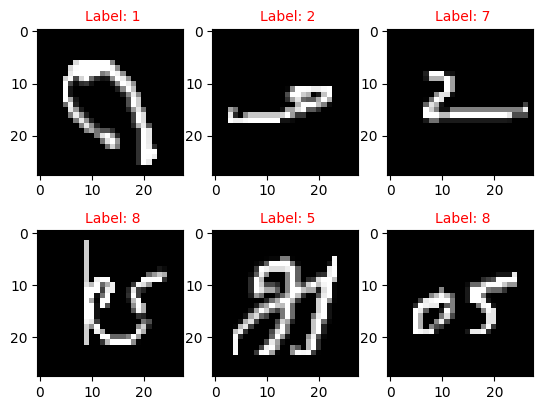

In [19]:
for i in range(6):
    label = val_df.iloc[:,0].values[i]
    image = torch.tensor(val_df.drop(val_df.iloc[:,0].name, axis=1).iloc[i,:].values).reshape(28,28,1)
    plt.subplot(2,3,i+1)
    plt.imshow(image, cmap='gray')
    plt.text(14, -2, f"Label: {label}", ha='center', fontsize=10, color='red')
plt.show()

In [20]:
from torch.utils.data import DataLoader

In [21]:
train_loader = DataLoader(dataset=train_dataset,batch_size=64,shuffle=True)
val_loader = DataLoader(dataset=val_dataset,batch_size=64,shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=64,shuffle=False)

In [27]:
class VAE(nn.Module):
    def __init__(self, D_in, H, D_out):
        super(VAE, self).__init__()
        self.D_in, self.H, self.D_out = D_in, H, D_out
        # Encoder layers (Gaussian MLP)
        self.input_layer = nn.Linear(D_in, H)
        self.hidden_layer_mean = nn.Linear(H, D_out)
        self.hidden_layer_var = nn.Linear(H, D_out)
        
        # Decoder layers (Bernoulli MLP for MNIST data)
        self.recon_layer = nn.Linear(D_out, H)
        self.recon_output = nn.Linear(H, D_in)
        self.tanh = nn.Tanh()
        self.sigmoid = nn.Sigmoid()
    
    def encode(self, inp):
        h_vec = self.input_layer(inp.float())
        h_vec = self.sigmoid(h_vec)
        means = self.hidden_layer_mean(h_vec)
        log_vars = self.hidden_layer_var(h_vec)
        return means, log_vars
    
    def decode(self, means, log_vars):
        # Reparametrization trick
        std_devs = torch.pow(2,log_vars)**0.5
        aux = MultivariateNormal(torch.zeros(self.D_out), \
        torch.eye(self.D_out)).sample()
        sample = means + aux * std_devs
        # Reconstruction
        h_vec = self.recon_layer(sample)
        h_vec = self.tanh(h_vec)
        output = self.sigmoid(self.recon_output(h_vec))
        return output
    
    def forward(self, inp):
        means, log_vars = self.encode(inp)
        output = self.decode(means, log_vars)
        return output, means, log_vars
    
    def reconstruct(self, sample):
        h_vec = self.recon_layer(sample)
        h_vec = self.tanh(h_vec)
        output = self.sigmoid(self.recon_output(h_vec))
        return output

In [31]:
def compute_loss(inp, recon_inp, means, log_vars):
    # Calculate reverse KL divergence
    # (formula provided in Kingma and Welling)
    kl_loss = -0.5 * torch.sum(1 + log_vars - means ** 2 - torch.pow(2,log_vars))
    # Calculate BCE loss
    loss = nn.BCELoss(reduction="sum")
    recon_loss = loss(recon_inp, inp.float())
    return kl_loss + recon_loss

In [37]:
D_in, H, D_out = 784, 500, 10
vae = VAE(D_in, H, D_out)
vae.to("cpu")

def train():
    vae.train()
    optimizer = optim.Adam(vae.parameters(), lr=1e-3)
    epochs = 50
    for epoch in range(epochs):
        for batch_idx, (data, _) in enumerate(train_loader):
            optimizer.zero_grad()
            #data = data.view((100,784))
            output, means, log_vars = vae(data)
            loss = compute_loss(data, output, means, log_vars)
            loss.backward()
            optimizer.step()
            if (batch_idx * len(data)) % 10000 == 0:
                print(
                    'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}' \
                    .format(
                        epoch, batch_idx * len(data), len(train_loader.dataset),
                        100. * batch_idx / len(train_loader), loss.item()))
    torch.save(vae.state_dict(), "vae.%d" % epoch)

In [38]:
train()

Train Epoch: 0 [0/8294 (0%)]	Loss: 74191.367188
Train Epoch: 1 [0/8294 (0%)]	Loss: -132914184.000000
Train Epoch: 2 [0/8294 (0%)]	Loss: -141404576.000000
Train Epoch: 3 [0/8294 (0%)]	Loss: -141664064.000000
Train Epoch: 4 [0/8294 (0%)]	Loss: -141585184.000000
Train Epoch: 5 [0/8294 (0%)]	Loss: -142518976.000000
Train Epoch: 6 [0/8294 (0%)]	Loss: -142936352.000000
Train Epoch: 7 [0/8294 (0%)]	Loss: -133478776.000000
Train Epoch: 8 [0/8294 (0%)]	Loss: -127960264.000000
Train Epoch: 9 [0/8294 (0%)]	Loss: -149357984.000000
Train Epoch: 10 [0/8294 (0%)]	Loss: -147256176.000000
Train Epoch: 11 [0/8294 (0%)]	Loss: -139585584.000000
Train Epoch: 12 [0/8294 (0%)]	Loss: -144589328.000000
Train Epoch: 13 [0/8294 (0%)]	Loss: -137709952.000000
Train Epoch: 14 [0/8294 (0%)]	Loss: -137585024.000000
Train Epoch: 15 [0/8294 (0%)]	Loss: -144078528.000000
Train Epoch: 16 [0/8294 (0%)]	Loss: -143997136.000000
Train Epoch: 17 [0/8294 (0%)]	Loss: -139908544.000000
Train Epoch: 18 [0/8294 (0%)]	Loss: -137790

In [39]:
def test():
    dist = MultivariateNormal(torch.zeros(D_out), torch.eye(D_out))
    vae = VAE(D_in, H, D_out)
    vae.load_state_dict(torch.load("vae.%d" % 9))
    vae.eval()
    outputs = []
    
    for i in range(100):
        sample = dist.sample()
        outputs.append(vae.reconstruct(sample).view((1,1,28,28)))
    outputs = torch.stack(outputs).view(100,1,28,28)
    save_image(outputs, "prior_reconstruct_100.png", nrow=10)

In [40]:
test()